# JWebbinar MIRISim: Walkthrough of MIRISim (MRS)
**Authors**: P. Klaassen & O. Jones (UK ATC) | **Latest update**: 26 Oct 2021

**MIRISim Version**: 2.4.1

--------------------------------------------------------------

    
In this notebook, we create a scene with a two point sources and a extended source (that all fit within the MIRI Medium Resolution Spectrometer IFU field of view), and run through a MIRISim simulation showing the products created at each stage.

### Steps in this notebook: <a class="anchor" id="steps"></a>

1. Create a Scene
2. Initialise the simulation parameters
3. Run the simulation
4. Examine some of the outputs.

## Table of contents
- [Resources](#resources) 
- [Installation Check](#installation) 
- [Import Libraries](#libraries)
- [Create a Scene](#scene) 
- [Initialise the Simulation](#Initialise)
- [Run the Simulation](#run) 
- [Examine some of the results](#results) 
- [Bonus: Running MIRISim with an APT file](#APTfile) 
- [Bonus: Some usefull functions](#function) 

## Resources <a class="anchor" id="resources"></a>
    
* [MIRISim Webpage maintained by the MIRISim development team](https://wiki.miricle.org/Public/MIRISim_Public)  
* [MIRISim Science Examples on github](https://github.com/JWST-MIRI/MIRISim-Science-Examples)  
* [Troubleshooting MIRISim installation](https://wiki.miricle.org/Public/MirisimInstallation#Troubleshooting)
* [STScI Webpage for JWebbinars](https://www.stsci.edu/jwst/science-execution/jwebbinars)
* [JWST Documentation (JDox) for JWST data products](https://jwst-docs.stsci.edu/obtaining-data)
* [The most up-to-date information about JWST data products in the pipeline readthedocs](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/index.html)
* [PySynphot](https://pysynphot.readthedocs.io/en/latest/)

## Installation Check <a class="anchor" id="installation"></a>

**NOTE:** This notebook must be started within the *mirisim anaconda environment*. This is a pre-requist for using MIRISim, and installation instructions can be found [here](https://wiki.miricle.org/Public/MirisimInstallation). The installation can be checked with the following Python commands:

``` 
python
    import miri
    print( miri.__version__ )
    import mirisim
    print( mirisim.version.__version__ )  
```

or via 
<code>mirisim --help</code> 


When launching the notebook, make sure you've run the appropriate version of  

<code>conda activate mirisim</code> 

in the terminal before starting the notebook: <code>jupyter notebook MIRISim_MRS_walkthrough_Webbinar.ipynb </code>

## Import the libraries used in this notebook:  <a class="anchor" id="libraries"></a>

In [1]:
#Basic system utilities
import numpy as np
import glob                 # glob is used to find the output directory
import os                   # for listing directory contents
from astropy.io import fits # for reading FITS file contents

# Import python packages used to display images inline in the notebook
import matplotlib.pyplot as plt    
from matplotlib import colors,cm
%matplotlib inline       

# Make the notebook screen space wider
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:89% !important; }</style>"))

In [2]:
# Now import MIRISim specific packages 

# import the configuration file parsers so they can be written to file
from mirisim.config_parser import SimConfig, SimulatorConfig, SceneConfig

# import scene component generators
from mirisim.skysim import Background, sed, Point, Galaxy, kinetics, ExternalSed
from mirisim.skysim import wrap_pysynphot as wS

from mirisim import MiriSimulation

In [3]:
# Setup a timer to keep track of runtime
from datetime import datetime

now = datetime.now()
start = now
start_time = now.strftime("%H:%M:%S")
#print("Start Time =", start_time)

##  Create a Scene  <a class="anchor" id="scene"></a>

Each scene should include at minimum: 1) a background level; 2) a science source. 

Targets in a scene can be generated using a range of spatial, spectral and velocity information. 
The spatial extent of the target should be set first, then spectral component, finaly a velocity map can be attributed to the target, which will modify its spectral specifications across the object.
**Hint:** Remember to import the scene component generators you wish to use when initialsing the notebook. 


#### Types of Targets: Spatial Specifications
<code>Background</code> -  Represents the Sky + Observatory background noise seen by MIRI in (muJy/arcsec^2).

<code>Point</code> - Represents a point source with SED provided for a given stellar type or from an external file.

<code>Galaxy</code> - Represents an extended object described by a Sersic index (n=1: exponential profile, n=4: de Vaoucouleurs) of the Galaxy.

<code>SersicDisk</code> - Represents an extended object described by a Sersic disk. 

<code>ExpDisk</code> - Represents an exponential profile Disk object.

All extended sources (<code>Galaxy</code>, <code>SersicDisk</code>, <code>ExpDisk</code>) have the added parameterisation of their spatial extents. Disk truncation radii can be set for extended objects, but spiral arms cannot. Note: Extended sources, such as Galaxy, with angular size smaller than a pixel may suffer from flux loss due to low spatial resolution. Please, use a point source (<code>Point</code>) or a skycube fits file (<code>Skyscene</code>) instead.


#### Types of Targets: Spectral Specifications

Users can set the spectral energy distributions (SEDs) for the target via a range of methods. The key types incude blackbodies <code>sed.BBSed</code>, and power law spectra <code>sed.PLSed</code>. These continuous SEDs take reference wavelengths (microns) and fluxes (microJy) as inputs as well as reference temperatures (K) and power-law indicies (respectively).


<code>Blackbody = sed.BBSed(Temp = 800., wref = 10., flux = 1e5)</code>


<code>PowerLaw = sed.PLSed(alpha=1.0,flux=5e5,wref=10.)</code>


Users can also define a set of spectral lines. Here the user sets as input the integrated intensities (10^-20 W/m^2) for each of the lines initialised at specified wavelengths and fwhms (in microns).

<code>lines_sed = LinesSed(wavels = [5.6,6.6], fluxes = [1.e4,1.e4], fwhms = [1e-3,1e-3])</code>


Alternatively users can specify SEDs using the models integrated into [PySynphot](https://pysynphot.readthedocs.io/en/latest/) <code>wS.PYSPSed</code>. There is a large range of available models to choose from, please refer to the documentation on the pysynphot website for a listing of the available models, expected input units for each model and wavelength ranges covered by those models. *Caution - many of these models **do not** extend to the MIRI wavelengths (5-28 microns).* 


Users may also import an external SED from text file of two columns: 1) wavelengths (in microns), 2) flux densities (in microJy). 

<code>ext_sed = ExternalSed(sedfile = 'sedext.txt')</code>

#### Types of Targets: Velocity Specifications

If your target is expected to be rotating a velocity map <code>set_velomap</code> can be applied to your extended object. This will shift the SED as a function of position within the galaxy/disk. A range of options are avaiable e.g., <code>FlatDisk</code>, <code>KeplerDisk</code>, <code>Losvd</code>. Please see the MIRISim documutation for more details. 


### Building our scene from component targets 

The scene created below consists of two point sources and an edge-on Galaxy, all three of which fit within the MIRI Medium Resolution Spectrometer (MRS) IFU field of view. The first point source has a blackbody SED, the second a pysynphot SED. The galaxy has a powerlaw SED, which is modified by a Keplerian velocity field.

#### Create a low level background for the scene

In [4]:
### Create a background level for the scene 
bg = Background(level='low',gradient=5., pa=45.)  # level = low or high

2021-10-26 14:48:03,969 - INFO - Initializing Background


#### Create the First Point Source


In [5]:
# initialise the point source with a position
point1 = Point(Cen = (-0.5,0.5))

# set properties of the SED
Blackbody = sed.BBSed(Temp = 800., wref = 10., flux = 1e5)  # Temp = K, wref = microns, flux = micro Jy 

# add the SED to the point source
point1.set_SED(Blackbody)

2021-10-26 14:48:03,975 - INFO - Initializing Point


#### Create the Second Point Source

In [6]:
# Initialise the point source with a position
point2 = Point(Cen = (0.5,0.5))

# Set the properties of the SED 
# The ‘bkmodels’ are the Buser-Kurucz stellar atmosphere models in the pysynphot Spectral Atlases
# This model has been normalised to a flux of 1.e5 micro Jy at 10 microns 
PYSPsedDict = {'family':'bkmodels','sedname':'bk_b0005','flux':1.e5, 'wref':10.}     
sedP2 = wS.PYSPSed(**PYSPsedDict)

# add the SED to the point source
point2.set_SED(sedP2)

2021-10-26 14:48:03,982 - INFO - Initializing Point


#### Create the an extended source (a galaxy) in the middle of the MRS field of view with a power law SED

In [7]:
# initialise an extended source (a galaxy) in the middle of the MRS field of view
galaxy = Galaxy(Cen = (0.,0.0),n=2.,re=1.2,q=0.1,pa=90)  # n = sersic idx; re = eff. rad. (arcsec) ; q = axis ratio ; pa = position angle (deg)

2021-10-26 14:48:04,059 - INFO - Initializing Galaxy
2021-10-26 14:48:04,060 - INFO - Initializing Galaxy
2021-10-26 14:48:04,061 - INFO - Initializing Galaxy


In [8]:
# set the properties of the SED - in this instance a power law is used. 
# an optional velocity shift (e.g., v = 20 in km/s) or Redshift (z = 0.4) can also be applied when setting the SED.

PowerLaw = sed.PLSed(alpha=1.0,flux=5e5,wref=10.)

# add the SED to the galaxy
galaxy.set_SED(PowerLaw)

In [9]:
# create a velocity mapping for the SED
VMAPpars = {'vrot': 200., 'Cen': (0., -0.5), 'pa': 90., 'q': 0.1, 'c': 0} # vrot = Rotational Velocity (km/s); c = measure of diskiness/boxiness
VelocityMap = kinetics.FlatDisk(**VMAPpars)

# add the velocity map to the galaxy
galaxy.set_velomap(VelocityMap)

2021-10-26 14:48:04,073 - INFO - Initializing FlatDisk


In [10]:
# add a line of sight velocity distribution to the galaxy - using a Gauss-Hermite expansion
losVeloDist = kinetics.Losvd(sigma=200.,h3=0.,h4=0.)
galaxy.set_LOSVD(losVeloDist)

2021-10-26 14:48:04,080 - INFO - Initializing Losvd


#### In this second example we will create an extended source with a flat SED and  six spectral lines in the 5 - 10 micron region with a FWHM of 1e-2 microns

In [11]:
# create an extended source in the middle of the MRS field of view
ext_src = Galaxy(Cen = (0.,0.), n = 2., re = 1.2, q = 0.5, pa = 35.)

2021-10-26 14:48:04,147 - INFO - Initializing Galaxy
2021-10-26 14:48:04,148 - INFO - Initializing Galaxy
2021-10-26 14:48:04,148 - INFO - Initializing Galaxy


After the object has been created the spectral perameters can now be set.

In [12]:
Nlines = 6         # nlines
line_peaks = 1e5   # Flambda - NOTE: lambda x Flambda = nu x Fnu
FWHM = 1e-2        # microns 

line_wavs = np.linspace(5,10,Nlines)  # Make an array for the line wavelenghts 
fwhms = np.full(Nlines, FWHM)         # Make an array for the FWHM

# Convert line peaks into integrated intensities for MIRISim to parse - units 10^-20 W/m^2
integ_flux = [line_peaks /((FWHM*y)*(np.sqrt(2*np.pi)))**2 for y in line_wavs ]

LINEpars = {'wavels': line_wavs,    # microns 
            'fluxes': integ_flux,   # 10^-20 W/m^2
            'fwhms': fwhms}         # microns 

lines = sed.LinesSed(**LINEpars)

# add the line SED to the extended source
ext_src.set_SED(lines)

Plot the source spatial and spectral infomation using the built in functions.

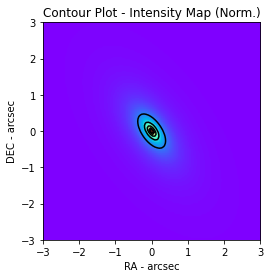

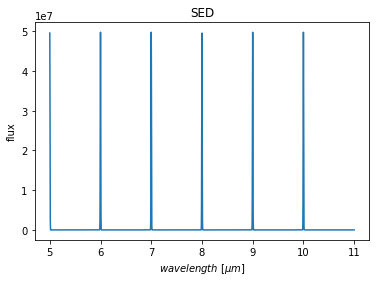

In [13]:
ext_src.plot_spatial(RArange=[-3,3],DErange=[-3,3],WArange=[4.9,5.1])
ext_src.plot_spec(wrange=[5,11])

### From the components, create a scene

Making a scene is as simple as adding together the targets.

In [14]:
scene = bg + point1 + point2 + galaxy

A target list can also be created for use in the scene configuration - this excludes the background. 

In [15]:
targetlist = [point1, point2, galaxy]

### Export the scene to an .ini file 

The scene can also be exported to an ini file (for future use), or a FITS file <code>scene.writecube</code> to be visualised.

Exporting to a FITS file requires specifing a number of aditional parametrs such as the Field of view, required spectral sampling, etc. For large fields of view, and/or small spectral channels, which create large FITS files, writing to a FITS file can take a while (few minutes). For details on this process see the MIRISim science example github repository or the MIRISim user guide. 

#### Create a scene configuration object for the simulation to come

In [16]:
scene_config = SceneConfig.makeScene(loglevel=0,
                                    background=bg,
                                    targets = [point1,point2,galaxy])

# export the scene_config to ini file
os.system('rm JWebbinar_scene.ini') 
scene_config.write('JWebbinar_scene.ini')

## Initialise the Simulation Parameters  <a class="anchor" id="Initialise"></a>

This is where the parameters for the MRS simulation get set. Note that for internal consistency in MIRISim, all settings (including those not used in the MRS simulation here) must be set. Those not being used in this MRS simulation are labelled with <code> NOT USED HERE </code> in the comments of each line. 

**Some KEY points:**

1) The outputs of MIRISim depend on which optical path (Imager/LRS/MRS) is being simulated.

2) <code>POP</code> sets which type of siumlation is run either: MRS or IMA. 

3) For the MRS the <code>ConfigPath</code> should be set to the MRS sub-band of your choice. There are 12 options - these  corespond to the four IFU channels (1-4), with each channel having three sub-bands (short, medium and long). Hint: To focus your sumulation on the same spot do not change the <code>ConfigPath</code> is switching between <code>disperser</code> options. 

4) To simulate the full 5-28 micron wavelenght range for the MRS you will need to run a minimum of 3 simulations. With the value for <code>disperser</code> modified each time to cover: <code>disperser = 'SHORT'</code> , <code>disperser = 'MEDIUM'</code> , <code>disperser = 'LONG'</code>. Here <code>detector = 'BOTH'</code> would retun outputs from both the SW and LW channels. If only <code>detector = 'SW'</code> or <code>detector = 'LW'</code> was slected a minimum of 6 simulations wold be needed to cover the 5-28 micron range.

5) For the imager the choice of subarrays can be set - for the Full array with a FOV of 74" × 113" set  <code>POP = 'IMA'</code> and <code>ConfigPath = 'IMA_FULL'</code>.

6) If you wish to run a LRS simulation the values <code>POP = 'IMA'</code> and <code>ConfigPath = 'LRS_SLIT'</code> should be selected. 

7) All keywords in <code>makeSim</code> must be set and present. Do NOT delete any of options even if the values are not relavent to your simulation. 

In [17]:
simulation_config = SimConfig.makeSim(
        name  = 'JWebbinar',           # name given to simulation
        scene = 'JWebbinar_scene.ini', # name of scene file to input
    
        rel_obsdate = 0.0,          # relative observation date (0 = launch, 1 = end of 5 yrs)
        POP = 'MRS',                # Component on which to center (Imager or MRS)
        ConfigPath = 'MRS_2SHORT',  # Configure the Optical path (MRS sub-band)

        ############################################################################################
        # This is where you set up your MRS parameters - adjust values spefific to your observation 
        # If doing a imager simulation set by POP='Imager' - these parameters would not be used by MIRISim 
        
        disperser = 'SHORT',        # Which disperser to use (SHORT/MEDIUM/LONG)
        detector = 'SW',            # Specify Channel (SW = channels 1,2, LW = channels 3,4, or BOTH)
        mrs_mode = 'FAST',          # MRS read mode (default is FAST; SLOW. ~ 24s)
        mrs_exposures = 1,          # number of exposures
        mrs_integrations = 1,       # number of integrations
        mrs_frames = 10,            # number of groups (for MIRI, # Groups = # Frames)
    
        ############################################################################################
        # This is where you set up your dither parameters - adjust values spefific to your observation 
        
        Dither = False,             # Don't Dither    
        StartInd = 1,               # Start index for dither pattern        [NOT USED HERE]
        NDither = 4,                # Number of dither positions            [NOT USED HERE]
        DitherPat = 'mrs_recommended_dither.dat', # Dither pattern to use   [NOT USED HERE]

        ############################################################################################
        # These parameters are not used in the MRS simulation and should not be adjusted (OR deleted)
        ima_exposures = 0,           # [NOT USED HERE]
        ima_integrations = 16,       # [NOT USED HERE]
        ima_frames = 14,             # [NOT USED HERE]
        ima_mode = 'FAST',           # [NOT USED HERE]
        filter = 'F1000W',           # [NOT USED HERE]
        readDetect = 'BRIGHTSKY'     # [NOT USED HERE]
        )

### Export the simulation setup to a file

In [18]:
os.system('rm JWebbinar_simulation.ini')
simulation_config.write('JWebbinar_simulation.ini')

## Run the simulation <a class="anchor" id="run"></a>

Now that the scene and the setup of the simulation have been set, we can run the simulation. The last step before runing the simulation is to setup the defaults for internal things like CDPs using the <code>SimulatorConfig</code> defaults.

In [19]:
simulator_config = SimulatorConfig.from_default()

# Now run the simulator
mysim = MiriSimulation(simulation_config,scene_config,simulator_config)
mysim.run()

2021-10-26 14:48:04,938 - INFO - MIRISim version: 2.4.1
2021-10-26 14:48:04,939 - INFO - MIRI Simulation started.
2021-10-26 14:48:04,940 - INFO - Output will be saved to: 20211026_144804_mirisim
2021-10-26 14:48:04,941 - INFO - Storing configs in output directory.
2021-10-26 14:48:08,980 - INFO - Reading cosmic ray properties from parameter file /Users/ojones/anaconda3/envs/mirisim/lib/python3.8/site-packages/miri/simulators/scasim/cosmic_ray_properties.py
2021-10-26 14:48:09,042 - INFO - Reading detector properties from parameter file /Users/ojones/anaconda3/envs/mirisim/lib/python3.8/site-packages/miri/simulators/scasim/detector_properties.py
2021-10-26 14:48:09,357 - INFO - Storing dither pattern in output directory.
2021-10-26 14:48:09,364 - INFO - Using $CDP_DIR for location of CDP files: /Users/ojones/Desktop/mirisim_egs/CDP
2021-10-26 14:48:09,365 - INFO - Setting up simulated Observation, with following settings:
2021-10-26 14:48:09,365 - INFO - Configuration Path: MRS_2SHORT


2021-10-26 14:52:16,942 - INFO - Detector temperature = 6.70 K (which affects dark current and read noise).
2021-10-26 14:52:16,942 - INFO - Cosmic ray environment is SOLAR_MIN.
2021-10-26 14:52:16,943 - INFO - Reading cosmic ray library file: '/Users/ojones/anaconda3/envs/mirisim/lib/python3.8/site-packages/miri/simulators/data/cosmic_rays/CRs_SiAs_470_SUNMIN_00.fits'
2021-10-26 14:52:17,030 - INFO - Simulation control flags:
	Quantum efficiency simulation turned OFF.
	Poisson noise simulation turned ON.
	Read noise simulation turned ON.
	Reference pixels simulation turned ON.
	Bad pixels simulation turned ON.
	Dark current simulation turned ON.
	Flat-field simulation turned ON.
	Amplifier bias and gain turned ON.
	Detector non-linearity effects turned ON.
	Detector drift effects turned ON.
	Detector latency effects turned ON.
2021-10-26 14:52:17,031 - INFO - No output subarray mode. Input subarray mode assumed FULL.
2021-10-26 14:52:17,032 - INFO - Input subarray mode assumed FULL
20

## Examine some of the results <a class="anchor" id="results"></a>

Now that the MIRISim simulation has completed, lets examine the results. 

The first thing to note is that the outputs are placed in a date-labelled directory taking the form  <code>YYYYMMDD_hhmmss_mirisim</code>.  The name of the output directory is given in the last line of the MIRISim log above.  Because the output directory is date-labelled, we can quantify which was the most recent run of MIRISim, and find its output directory using <code>glob.glob</code>

In [20]:
outputdir = sorted(glob.glob('*_*_mirisim'),key=os.path.getmtime)[-1]    #[-1] takes the last entry found

outputDirContents = os.listdir(outputdir)

directories = [name for name in outputDirContents if os.path.isdir(os.path.join(outputdir,name))]
files = [name for name in outputDirContents if not os.path.isdir(os.path.join(outputdir,name))]

print('The subdirectories in the outputdirectory are:\n{}\n'.format(directories)) 
print('The files in the outputdirectory are:\n{}'.format(files))

The subdirectories in the outputdirectory are:
['det_images', 'skycubes', 'illum_models']

The files in the outputdirectory are:
['simulator.ini', 'scene.ini', 'mrs_recommended_dither.dat', 'simulation.ini', 'mirisim.log']


The files contain the log which was also output to the terminal (<code>mirisim.log</code>) and copies of the .ini files used (or created from python inputs) to create the simulation. These versions of the .ini files can be used to re-create the run of the simulation

The directories contain various outputs of MIRISim:

* **<code> skycubes </code>** houses a 3D representation of the input scene to the MRS simulation (skycubes are not generated for imager or LRS simulations). This cube has not been processed by MIRISim, it is simply a gridded (spatially and spectrally) version of the input scene.  
* **<code> illum_models </code>** houses FITS images of the illuminations sent to the detector (sent to SCAsim - the simulator of the Sensor Chip Assembly).  This should have the same format as the detector image, but without all of the detector effects and noise. There are FITS files produced for each exposure and dither position
* **<code> det_images </code>** houses FITS images of the final outputs of MIRISim. These detector images have all of the detector effects and noise incorporated. The number of detector images should be the same as the number of illumination models. 

The headers of the detector images are formatted for ingest into the JWST pipeline. 

Below is a small code snippet used to draw the images.  it needs to be run, but doesn't produce any output directly (it's called later to show the output images)

In [21]:
def show_outputs(MIRISim_outputdir,output_type):
    '''
    plot the specified channel of the MIRISim outputs
    :param MIRISim_outputdir:  
        name of the date-labelled dir. holding the MIRISIM outputs
    :param output_type: 
        type of output to process 
        (e.g. illum_models, det_images or skycubes)
    '''
    
    infits = glob.glob('{}/{}/*.fits'.format(MIRISim_outputdir,output_type))[0]
    
    hdulist = fits.open(infits)
    
    if output_type.lower() == 'skycubes': 
        hdu_index = 0
        datashape = hdulist[hdu_index].data.shape
        central_chan = datashape[0]//2
        
        plt.imshow(hdulist[hdu_index].data[central_chan,:,:],
           origin = 'lower', interpolation = 'nearest',cmap = cm.viridis)
        plt.title('channel {} of {}'.format(central_chan,infits.split('/')[-1]))
        plt.xlabel(hdulist[hdu_index].header['ctype1'])
        plt.ylabel(hdulist[hdu_index].header['ctype2'])
    else:
        hdu_index = 1
        if len(hdulist[hdu_index].data.shape) > 2:
            integ,frames,nx,ny = hdulist[hdu_index].data.shape
            image = hdulist[hdu_index].data[integ-1,frames-1,:,:]
        else:
            image = hdulist[hdu_index].data
            
        
        plt.imshow(image, origin = 'lower',cmap = cm.viridis,interpolation='nearest')
        plt.title('{}'.format(infits.split('/')[-1]))
        plt.xlabel('Along Slice Direction')
        plt.ylabel('Wavelength Direction')

    plt.colorbar()
    plt.savefig('MRS_{}.png'.format(output_type))

### Viewing a slice of the skycube

Below, we show an image of the central channel of one of the skycubes generated by MIRISim

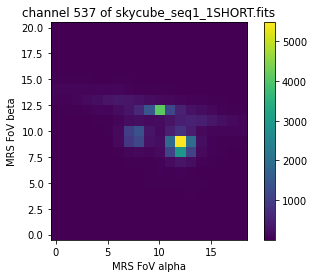

In [22]:
show_outputs(outputdir,'skycubes')

### Viewing an illumination model

Below shows an example of an output illumination model

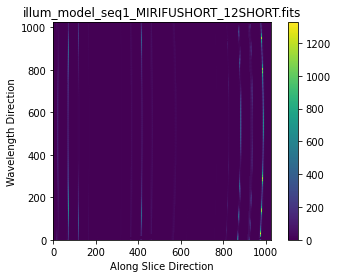

In [23]:
show_outputs(outputdir,'illum_models')

or doing this manually:

Filename: 20211026_144804_mirisim/illum_models/illum_model_seq1_MIRIFUSHORT_12SHORT.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      30   ()      
  1  INTENSITY     1 ImageHDU        45   (1024, 1024)   float32   
  2  WAVELENGTH    1 ImageHDU        13   (1024, 1024)   float32   
  3  ASDF          1 BinTableHDU     11   1R x 1C   [1858B]   


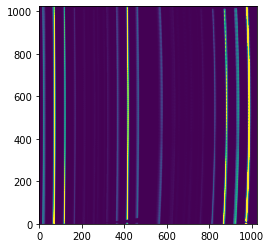

In [24]:
#Show illumination model
infits = glob.glob('{}/illum_models/*.fits'.format(outputdir))[0]

hdulist = fits.open(infits)
hdulist.info()

data = hdulist[1].data

dmin,dmax = np.min(data),np.max(data)

plt.imshow(hdulist[1].data,origin='lower',vmin = 50*dmin,vmax=0.1*dmax,cmap=cm.viridis);

## Viewing the final detector image

The detector images are the final output of MIRISim, and have data structures and formatting consistent with what will come from MIRI itself. The data format is JWST pipeline ready.  Below an example image of the last frame of the last integration is shown. The units are <code>DN</code>.

Additionally, below the FITS header information for the SCIENCE extension is listed

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    4 / number of array dimensions                     
NAXIS1  =                 1032                                                  
NAXIS2  =                 1024                                                  
NAXIS3  =                   10                                                  
NAXIS4  =                    1                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
EXTNAME = 'SCI     '           / extension name                                 
                                                                                
        Information about the coordinates in the file                           
                            

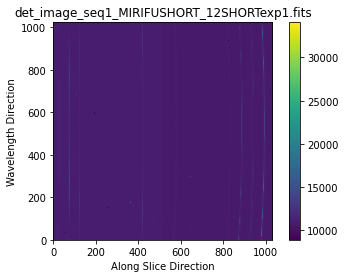

In [25]:
show_outputs(outputdir,'det_images')

infits = glob.glob('{}/det_images/*.fits'.format(outputdir))[0]
hdulist = fits.open(infits)
hdulist[1].header

To examine each of the detector images:

Filename: 20211026_144804_mirisim/det_images/det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     118   ()      
  1  SCI           1 ImageHDU        51   (1032, 1024, 10, 1)   float32   
  2  PIXELDQ       1 ImageHDU        11   (1032, 1024)   int32 (rescales to uint32)   
  3  REFOUT        1 ImageHDU        11   (258, 1024, 10, 1)   float32   
  4  ASDF          1 BinTableHDU     11   1R x 1C   [5848B]   


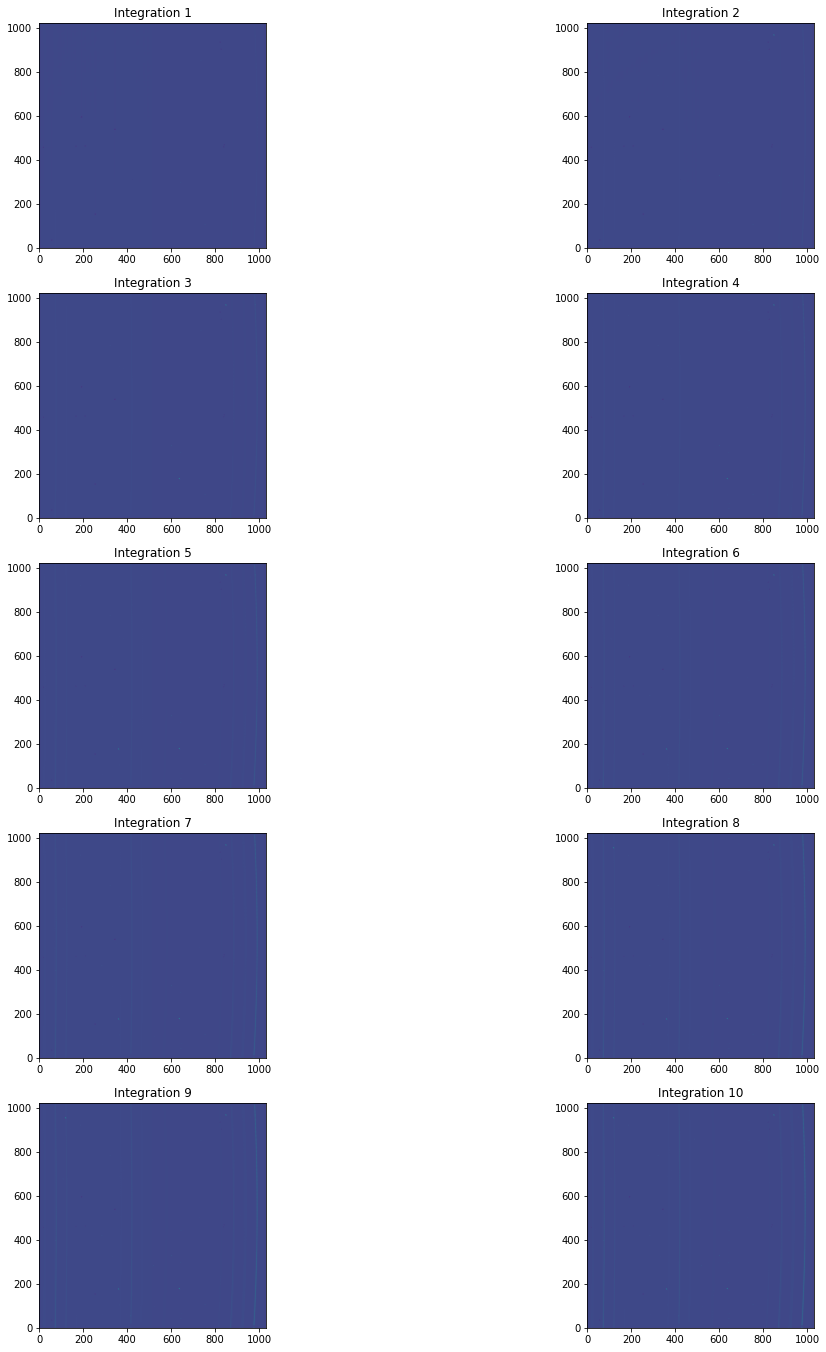

In [26]:
#show final detector image

infits = glob.glob('{}/det_images/*.fits'.format(outputdir))[0]
hdulist = fits.open(infits)
hdulist.info()

data = hdulist[1].data
dmin,dmax = np.min(data),np.max(data)
fig = plt.figure(figsize=(18,24))
for i in range(0,10):
    plt.subplot(5,2,i+1)
    plt.imshow(data[0,i,:,:],origin='lower',vmin=dmin,vmax= dmax,cmap=cm.viridis)
    plt.title("Integration {}".format(i+1))

# The outputs of MIRISim can now be run through the JWST pipeline see:
https://jwst-docs.stsci.edu/jwst-data-reduction-pipeline and https://jwst-pipeline.readthedocs.io/en/stable/



## Bonus: Running MIRISim with an APT file <a class="anchor" id="APTfile"></a>

Instead of setting the <code>Simulation Parameters</code> manually it possible to use MIRISim with the simulation properties provided by a complete APT file.

An example is given below. Here the ####.apt is the name of the APT file to be parsed, and scene.ini describes the scene to be used for all
observations executed in the APT file.

A word of caution - the APT is being continuously updated. Future-proofing is not guaranteed especially if the observation setup changes inside the APT. If they do, the APT parser may break.

In [27]:
# First import the relevant mirisim modules to parse an APT file
import miri.apt_parser
import mirisim.apt
miri.apt_parser.init_log()
from mirisim import config_parser as parser 

In the APT file, there will be a list of targets to be associated with the various observations. These targets have a target number pre-pended to their names by the APT (i.e.'1 NGC-188-FTS107-1'). This number (and following space) is required to be included as part of the target name when specifying a dictionary of scenes.

In [28]:
# create a scene using the default parameters to simplify the example
scene_config = parser.SceneConfig.from_default()

2021-10-26 14:52:37,519 - INFO - Initializing Background
2021-10-26 14:52:37,595 - INFO - Initializing Point
2021-10-26 14:52:37,596 - INFO - Initializing Point
2021-10-26 14:52:37,628 - INFO - Initializing Point
2021-10-26 14:52:37,646 - INFO - Initializing Point
2021-10-26 14:52:37,647 - INFO - Initializing Point
2021-10-26 14:52:37,722 - INFO - Initializing FlatDisk
2021-10-26 14:52:37,724 - INFO - Initializing Losvd
2021-10-26 14:52:37,725 - INFO - Initializing Galaxy
2021-10-26 14:52:37,726 - INFO - Initializing Galaxy
2021-10-26 14:52:37,726 - INFO - Initializing Galaxy


In [29]:
# create a scene dictionary where each of the scenes to be observed comes
# from the scene_configuration defined above (i.e. they're all the same)
scene = {
        '1 NGC-188-FTS107-1':scene_config,
        '2 NGC-188-FTS107-2':scene_config,
        'NONE':scene_config, # for an observation with no target defined
        }

Now read MIRI observations from the APT file e.g., 
<code>observations = miri.apt_parser.parse_apt("1232.aptx")</code>

and run a MIRISim simulation using the observation specifications from the APT file

<code>mirisim.apt.run(observations, scene_config)</code>

**or**

run the simulation with the dictionary of scene configurations, rather than a single scene

<code>mirisim.apt.run(observations, scene)</code>

In [30]:
# read the MIRI observations from the APT file
#observations = miri.apt_parser.parse_apt("1232.aptx")

In [31]:
# run a MIRISim simulation using the observation specifications from the APT file
#mirisim.apt.run(observations, scene_config)

# OR

# run the simulation with the dictionary of scene configurations, rather than a single scene
#mirisim.apt.run(observations, scene)

## Bonus: Using a FITS file for your scene  <a class="anchor" id="FITS"></a>

The <code>SkySim</code> can interpret a FITS files rather than the user manually generating their own scene. The following keywords must be present in the fits header: 
``` 
NAXIS = 3
NAXISi = #of pixels
CTYPEi = (see below)
CRVALi = reference values
CRPIXi = pixel for reference value
CDELTi = size of pixel
``` 

Where the CTYPEi values take the form ‘RA—TAN’,’DEC–TAN’, and ‘WAVE'. When Skysim is interpreting the input grid, it calculates values relative to a pixel center. This allows FITS file inputs to be combined with additional sources in the field of view through specifying them in a scene.

To import a FITS cube within python:

``` 
from mirisim.skysim import Skycube
FITSCUBE = myfile.fits
s = Skycube(FITSCUBE)
``` 

## Bonus: Useful functions for making a scene  <a class="anchor" id="functions"></a>

- <code>create_star_Phoenix</code> Makes a point source at a location with an SED corresponding to a stellar Phoenix model.
- <code>create_star_T</code>  Makes a point source at a location with an SED corresponding to a blackbody of a give temprature.
- <code>setup_PD</code> Makes a ‘protoplanetary disks’a location with an SED corresponding to a blackbody of a give temprature.



In [32]:
def create_star_Phoenix(xpos, ypos, Temp=3500, FeH=0.0, logg = 4.44, Fl=1e3, wref=10.0):
    """ Makes a star (point source) instance with given initialisation parameters for Phoenix SED

    :param xpos: RA offset from center of scene [arcsec]
    :param ypos: Dec offset from center of scene [arcsec]
    :param Temp: BB temperature = 3500 default [Kelvin]
    :param FeH: Metallicity = 0.1 = solar as default [M/H]
    :param logg: log surface gravity = 4.44 = solar as default [cm/s2]
    :param Fl: Flux to normalise to  = 1e3 default [micro Jy] 
    
    :return: A point source (star) at a specific location initialised with a Phoenix SED
    :rtype: mirisim.skysim.basicsources.Point
    :raises: None
    """    
    star = Point(Cen = (xpos,ypos))        # RA, Dec ofset from center of scene [arcsec]
    pheSED = wS.PYSPSed(family='phoenix', sedpars=[Temp, FeH, logg], flux=Fl, wref=wref)     
    star.set_SED(pheSED)
    
    return star

In [33]:
def create_star_T(xpos,ypos, Temp=3500, Fl=1e2, wref=10.0):
    """ Makes a star (point source) instance with given initialisation parameters for a blackbody SED

    :param xpos: RA offset from center of scene [arcsec]
    :param ypos: Dec offset from center of scene [arcsec]
    :param Temp: BB temperature = 3500 default [Kelvin]
    :param Fl: Flux to normalise to  = 1e1 default [micro Jy] 
    
    :return: A point source (star) at a specific location initialised with a blackbody SED
    :rtype: mirisim.skysim.basicsources.Point
    :raises: None
    """   
    star = Point(Cen = (xpos,ypos))        # RA, Dec ofset from center of scene [arcsec]
    BBparams = {'Temp': Temp,              # BB temperature = 3500 default [Kelvin]
                'wref': wref,              # Microns
                'flux': Fl}                # Flux to normalise to  = 1e2 default [micro Jy] 
    Blackbody = sed.BBSed(**BBparams)
    star.set_SED(Blackbody)
    
    return star

In [34]:
def setup_PD(xpos, ypos, PA=90, Axratio=0.7, Re=18, Tr_in=1., Tr_out=3.25, Temp=300, Fl=1.4e5, wref=10.0):
    """ Makes a ‘protoplanetary disks’ a (Sersic disk where n=1) instance with given initialisation parameters for a blackbody SED

    :param xpos: RA offset from center of scene [arcsec]
    :param ypos: Dec offset from center of scene [arcsec]
    :param PA: Position angle of the min/maj. axes [degrees]
    :param Axratio: Axis ratios
    :param Re: scale length of disk 
    :param Tr_in: where to truncate the inner rad.
    :param Tr_out: where to truncate the outer rad. 
    
    
    :param Temp: BB temperature = 300 default [Kelvin]
    :param Fl: Flux to normalise to  = 1.4e5 default [micro Jy] 
    
    :return: A Sersic Disk  at a specific location initialised with a blackbody SED
    :rtype: mirisim.skysim.basicsources.Point
    :raises: None
    """       
    
    
    # setup the spatial part of the disk
    PD = SersicDisk(Cen = (xpos,ypos),      # where to centre the disk - RA, Dec ofset from center of scene [arcsec]
                    pa = PA,                # position angle of the min/maj. axes
                    q = Axratio,            # axis ratios
                    n = 1,                  # sersic index (1 = expontential disk)
                    re = Re,                # scale length of disk
                    rtrunc_in = Tr_in,      # where to truncate the inner rad.
                    rtrunc_out = Tr_out     # where to truncate the outer rad.)                  
                    )
    
    # setup the spectral part of the disk
    BBparams = {'Temp': Temp,              # BB temperature = 300 default [Kelvin]
                'wref': wref,              # ref wave. for flux scaling = 10 Microns default
                'flux': Fl}                # Flux to normalise to 1.4e5 at the reference wavelength [micro Jy] 
    Blackbody = sed.BBSed(**BBparams)
    
    # attach the SED to the spatial spec. of the disk
    PD.set_SED(Blackbody)
    return PD

In [35]:
now = datetime.now()
complete = now
end_time = now.strftime("%H:%M:%S")

print("Start Time =", start_time)
print("End Time =", end_time)

duration = complete - start
duration_in_s = duration.total_seconds()
print("Duration = ", duration_in_s)

Start Time = 14:48:03
End Time = 14:52:37
Duration =  273.817591
